# **📘 Title: Feedforward Neural Network using Flux.jl in Julia**
Author: Umair



---



## **📌 Table of Contents**
*------- All Commented down in the code -------*

Objective

Libraries and Setup

Data Preparation

Model Architecture

Training the Model

Evaluation and Results

Conclusion and Improvements



---



## **🎯 Objective**

The goal of this project is to implement a simple feedforward neural network using Flux.jl to classify the MNIST dataset. This assignment helps us understand how to use Julia and Flux for deep learning model development, training, and evaluation.



Loading and preparing data...
Creating model...
Training model...
Epoch 1: Loss = 1.2807407, Test Accuracy = 0.8087
Epoch 2: Loss = 0.53817576, Test Accuracy = 0.871
Epoch 3: Loss = 0.40430242, Test Accuracy = 0.8969
Epoch 4: Loss = 0.35484317, Test Accuracy = 0.9047
Epoch 5: Loss = 0.32908154, Test Accuracy = 0.911
Epoch 6: Loss = 0.31219137, Test Accuracy = 0.9128
Epoch 7: Loss = 0.29743358, Test Accuracy = 0.9176
Epoch 8: Loss = 0.28425947, Test Accuracy = 0.9197
Epoch 9: Loss = 0.2717491, Test Accuracy = 0.9227
Epoch 10: Loss = 0.26026645, Test Accuracy = 0.9267
Evaluating and visualizing results...

Final Test Accuracy: 0.9267


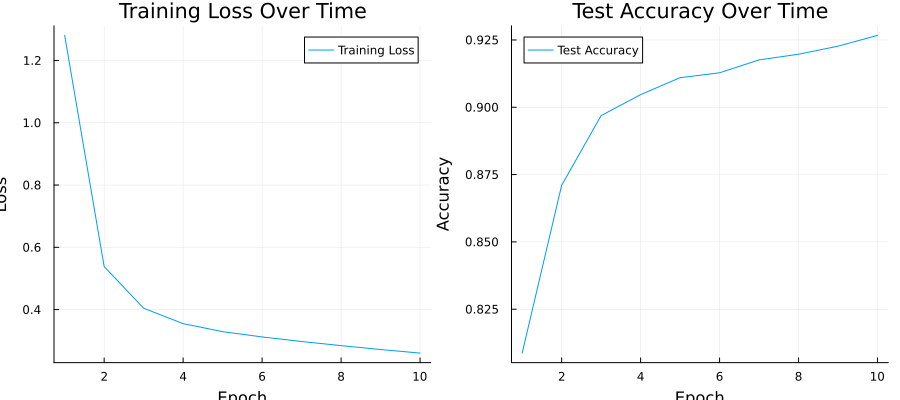

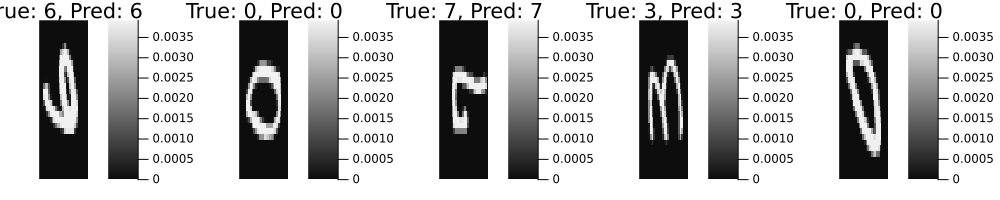

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 64, relu),               # 8_256 parameters
  Dense(64 => 10),                      # 650 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 109_386 parameters, 427.594 KiB.

In [ ]:
using Flux
using MLDatasets
using Statistics
using Plots
using Random

# Set random seed for reproducibility
Random.seed!(123)

# 1. Data Preparation
function prepare_data()
    # Load MNIST data (using updated syntax)
    train_data = MNIST(split=:train)
    test_data = MNIST(split=:test)

    # Extract features and labels
    train_x = Float32.(reshape(train_data.features, 28*28, :))
    test_x = Float32.(reshape(test_data.features, 28*28, :))

    # Normalize pixel values
    train_x = train_x ./ 255.0f0
    test_x = test_x ./ 255.0f0

    # Convert labels to one-hot encoding (adjust if your MNIST version uses different indexing)
    train_labels = train_data.targets
    test_labels = test_data.targets

    # Ensure labels are 0-indexed (some MNIST versions are 1-indexed)
    if maximum(train_labels) > 9 || maximum(test_labels) > 9
        train_labels = train_labels .- 1
        test_labels = test_labels .- 1
    end

    train_y = Flux.onehotbatch(train_labels, 0:9)
    test_y = Flux.onehotbatch(test_labels, 0:9)

    return train_x, train_y, test_x, test_y
end

# 2. Model Architecture
function create_model()
    return Chain(
        Dense(784, 128, relu),
        Dense(128, 64, relu),
        Dense(64, 10),
        softmax
    )
end

# 3. Training Loop
function train_model(model, train_x, train_y, test_x, test_y; epochs=10, batch_size=128)
    # Define loss function
    loss(x, y) = Flux.crossentropy(model(x), y)

    # Setup optimizer with current Flux API
    opt = Adam(0.001)

    # Setup optimizer state (required in newer Flux versions)
    opt_state = Flux.setup(opt, model)

    # Create data loader for batching
    data = Flux.DataLoader((train_x, train_y), batchsize=batch_size, shuffle=true)

    # Training history
    train_losses = Float32[]
    test_accuracies = Float32[]

    # Training loop
    for epoch in 1:epochs
        # Training phase
        epoch_loss = 0.0f0
        num_batches = 0

        for (x, y) in data
            # Compute gradients with updated API
            loss_value, grads = Flux.withgradient(model) do m
                batch_loss = Flux.crossentropy(m(x), y)
                return batch_loss
            end

            # Update model parameters with current API
            Flux.update!(opt_state, model, grads[1])

            epoch_loss += loss_value
            num_batches += 1
        end

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / num_batches
        push!(train_losses, avg_epoch_loss)

        # Calculate test accuracy
        test_preds = Flux.onecold(model(test_x), 0:9)
        test_labels = Flux.onecold(test_y, 0:9)
        test_accuracy = mean(test_preds .== test_labels)
        push!(test_accuracies, test_accuracy)

        println("Epoch $epoch: Loss = $avg_epoch_loss, Test Accuracy = $test_accuracy")
    end

    return train_losses, test_accuracies
end

# 4. Evaluation and Visualization
function evaluate_and_visualize(model, test_x, test_y, train_losses, test_accuracies)
    # Final test accuracy
    test_preds = Flux.onecold(model(test_x), 0:9)
    test_labels = Flux.onecold(test_y, 0:9)
    final_accuracy = mean(test_preds .== test_labels)
    println("\nFinal Test Accuracy: $final_accuracy")

    # Plot training loss
    p1 = plot(train_losses, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Time")

    # Plot test accuracy
    p2 = plot(test_accuracies, label="Test Accuracy", xlabel="Epoch", ylabel="Accuracy", title="Test Accuracy Over Time")

    # Display plots side by side
    display(plot(p1, p2, layout=(1, 2), size=(900, 400)))

    # Visualize some predictions
    function visualize_predictions(num_samples=5)
        # Select random test examples
        indices = rand(1:size(test_x, 2), num_samples)

        # Make predictions
        samples = test_x[:, indices]
        true_labels = test_labels[indices]
        pred_labels = test_preds[indices]

        # Create a plot for each example
        plots = []
        for i in 1:num_samples
            img = reshape(samples[:, i], 28, 28)
            p = heatmap(img, color=:grays, axis=false, title="True: $(true_labels[i]), Pred: $(pred_labels[i])")
            push!(plots, p)
        end

        # Display the plots
        display(plot(plots..., layout=(1, num_samples), size=(200*num_samples, 200)))
    end

    # Show some example predictions
    visualize_predictions()
end

# Main execution
function main()
    println("Loading and preparing data...")
    train_x, train_y, test_x, test_y = prepare_data()

    println("Creating model...")
    model = create_model()

    println("Training model...")
    train_losses, test_accuracies = train_model(model, train_x, train_y, test_x, test_y, epochs=10)

    println("Evaluating and visualizing results...")
    evaluate_and_visualize(model, test_x, test_y, train_losses, test_accuracies)

    return model
end

# Run the main function
model = main()